In [1]:
# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter


/home/vincent/NA_Model_Evaluation/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

# Improved CICIDS2017

In [3]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df

    

In [4]:
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = ['monday.csv', 
                  'tuesday.csv', 
                  'wednesday.csv', 
                  'thursday.csv', 
                  'friday.csv']


def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
    dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                    'Dst Port', 'Timestamp']
    improved_df = clean_df(improved_df)
    improved_df.drop(dropping_cols, axis = 1, inplace = True)
    improved_df['Label'].value_counts()    
    return improved_df
improved_df = read_csv()

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


In [5]:
improved_df['Label'].value_counts()

Label
BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                    

In [6]:
improved_df['Attempted Category'].value_counts()

Attempted Category
0    2092837
1       4067
6       2804
5        138
4         75
3         27
2         23
Name: count, dtype: int64

In [7]:
attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]

improved_df.drop(['Attempted Category'], axis = 1, inplace = True)

improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
improved_df['Label'].value_counts()

Label
BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [8]:
#### Sample out Malicious data such that it would become an outlier
print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
print(f'improved_df.shape {improved_df.shape} after Sampling Out')

improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1746169, 83) after Sampling Out


In [9]:
ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

Ratio of Benign to Anomaly is 10.516062230839747 : 1


# Train, validation, and test split

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()

In [11]:
Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
X = improved_df.copy().drop(columns=["Label"], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

train_perc = 0.15

# benign trainin and testing

X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    Y,
                                                    test_size = 1-train_perc, 
                                                    shuffle = True, 
                                                    stratify = Y, 
                                                    random_state = 0)




In [12]:
from sklearn import metrics

def get_score(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(confusion_matrix)

In [13]:
idx = np.where(y_train==1)
idx

(array([     9,     14,     23, ..., 261889, 261909, 261921]),)

In [14]:
# y = np.zeros_like(y_train.values)
# y[:2] = 1
# clf = PReNet( device = 'cuda', verbose=1, epochs=1)
# clf.fit(X=X_train.to_numpy(), y = y)

In [15]:
# pred = clf.predict(X_test.to_numpy())
# get_score(pred, y_test)


In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Example data
# anomaly_scores = clf.decision_function(X_test.to_numpy())




# Model Evaluations

## Unsupervised

In [28]:
def plot_graph(anomaly_scores, y_test):
    # Separate anomaly scores based on the labels
    scores_inliers = anomaly_scores[y_test == 0]  # Assuming '0' is the label for inliers
    scores_outliers = anomaly_scores[y_test == 1]  # Assuming '1' is the label for outliers

    # Create the plots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted for better visualization

    # Plot for inliers and outliers
    ax[0].hist(scores_inliers, bins=100, alpha=0.7, label='Inliers', log=True)
    ax[0].hist(scores_outliers, bins=100, alpha=0.7, label='Outliers', log=True)
    ax[0].set_title('Distribution of Anomaly Scores')
    ax[0].set_xlabel('Anomaly Score')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.95, 1.01])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, anomaly_scores)
    pr_auc = auc(recall, precision)
    ax[2].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.5f)' % pr_auc)
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('Precision-Recall Curve')
    ax[2].legend(loc="lower left")

    # Show the plot
    plt.show()

# Example usage
# anomaly_scores = np.array([...])  # Your anomaly scores array
# y_test = np.array([...])  # Your ground truth labels array
# plot_graph(anomaly_scores, y_test)

def plot_comparison_graph(metrics_dict, supervision_rate_list):
  fig, ax = plt.subplots(4, 1, figsize=(10, 16))  # Create a figure and a set of subplots.

  # Plot ROC curves on the first subplot
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[0].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[0].set_title('ROC Curve Comparison')
  ax[0].set_xlabel('False Positive Rate')
  ax[0].set_ylabel('True Positive Rate')
  ax[0].legend()
  ax[0].grid(True)
  
  for rate, fpr in metrics_dict['fpr'].items():
      tpr = metrics_dict['tpr'][rate]
      roc_auc = auc(fpr,tpr)
      ax[1].plot(fpr, tpr, label=f'Supervision {rate*100:.0f}%, area {roc_auc:.5f}')
  ax[1].set_title('ROC Curve Comparison')
  ax[1].set_xlabel('False Positive Rate')
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_ylim([0.9,1.02])
  ax[1].legend()
  ax[1].grid(True)  

  # Plot Precision-Recall curves on the second subplot
  for rate, precision in metrics_dict['precision'].items():
      recall = metrics_dict['recall'][rate]
      pr_auc = auc(recall,precision)
      ax[2].plot(recall, precision, label=f'Supervision {rate*100:.0f}%, area {pr_auc:.5f}')
  ax[2].set_title('Precision-Recall Curve Comparison')
  ax[2].set_xlabel('Recall')
  ax[2].set_ylabel('Precision')
  ax[2].legend()
  ax[2].grid(True)
  
  rate_list = [rate for rate in supervision_rate_list]
  accuracy_list = [metrics_dict['accuracy'][rate] for rate in rate_list]  # Corrected access to accuracy
  labels = [f"{rate*100:.0f}, {metrics_dict['accuracy'][rate]:.5f}" for rate in rate_list]  # Convert rates to percentage labels

  # Set the width of the bars to make them narrower
  bar_width = 0.4  # Smaller value results in narrower bars
  bars = ax[3].bar(labels, accuracy_list, color='skyblue', width=bar_width)

  # Adding labels to each bar
  for bar in bars:
      yval = bar.get_height()
      ax[3].text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  
  ax[3].set_xlabel('Supervision Rate (%)')
  ax[3].set_ylabel('Accuracy')
  ax[3].set_title('Model Accuracy at Different Supervision Rates')
  ax[3].set_ylim([0, 1.05])  # Assuming accuracy values are normalized [0,1]
  ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)
  
  plt.tight_layout()
  plt.show()    
  
  
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


In [18]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(anomaly_rate_list, model):
  supervision_rate = 0.25
  for anomaly_rate in anomaly_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    print(Y.value_counts())
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
      # y[12:14] = 1
      # y[:2] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    print(Counter(y))
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    pred = clf.predict(X_test.to_numpy())
    get_score(pred, y_test)
    print(y_test.value_counts())
    anomaly_scores = clf.decision_function(X_test.to_numpy())
    # Separate anomaly scores based on the labels
    plot_graph(anomaly_scores, y_test)



anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate = [1.0, 0.5, 0.25, 0.1, 0.05, 0]
model = PReNet
eval_model_unsupervised(anomaly_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (2099971, 83) after Sampling Out
Ratio of Benign to Anomaly is 3.1548124274134355 : 1
Label
0.0    1594540
1.0     505431
Name: count, dtype: int64
SEMI SUPERVISED, Sampling Rate = 1.0, Supervision = 0.25
Counter({0.0: 296042, 1.0: 18953})
Start Training...
ensemble size: 1


KeyboardInterrupt: 

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 1.0
Start Training...
ensemble size: 1
epoch  1, training loss: 0.136950, time: 265.6s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.5
Start Training...
ensemble size: 1
epoch  1, training loss: 0.174346, time: 262.6s
Start Inference on the training data...
Accuracy: 0.9998
Precision: 0.9883
Recall: 0.9975
F1 Score: 0.9928
[[1355306     252]
 [     54   21229]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.25
Start Training...
ensemble size: 1
epoch  1, training loss: 0.187936, time: 262.8s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.1
Start Training...
ensemble size: 1
epoch  1, training loss: 0.172567, time: 261.8s
Start Inference on the training data...
Accuracy: 0.9996
Precision: 0.9751
Recall: 0.9970
F1 Score: 0.9860
[[1355298     534]
 [     62   20947]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.176534, time: 267.2s
Start Inference on the training data...


invalid value encountered in divide
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Accuracy: 0.9844
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
[[1355360   21481]
 [      0       0]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
UNSUPERVISED, Sampling Rate = 0.05
Start Training...
ensemble size: 1
epoch  1, training loss: 0.087790, time: 267.0s
Start Inference on the training data...
Accuracy: 0.9882
Precision: 0.2499
Recall: 0.9833
F1 Score: 0.3985
[[1355269   16113]
 [     91    5368]]


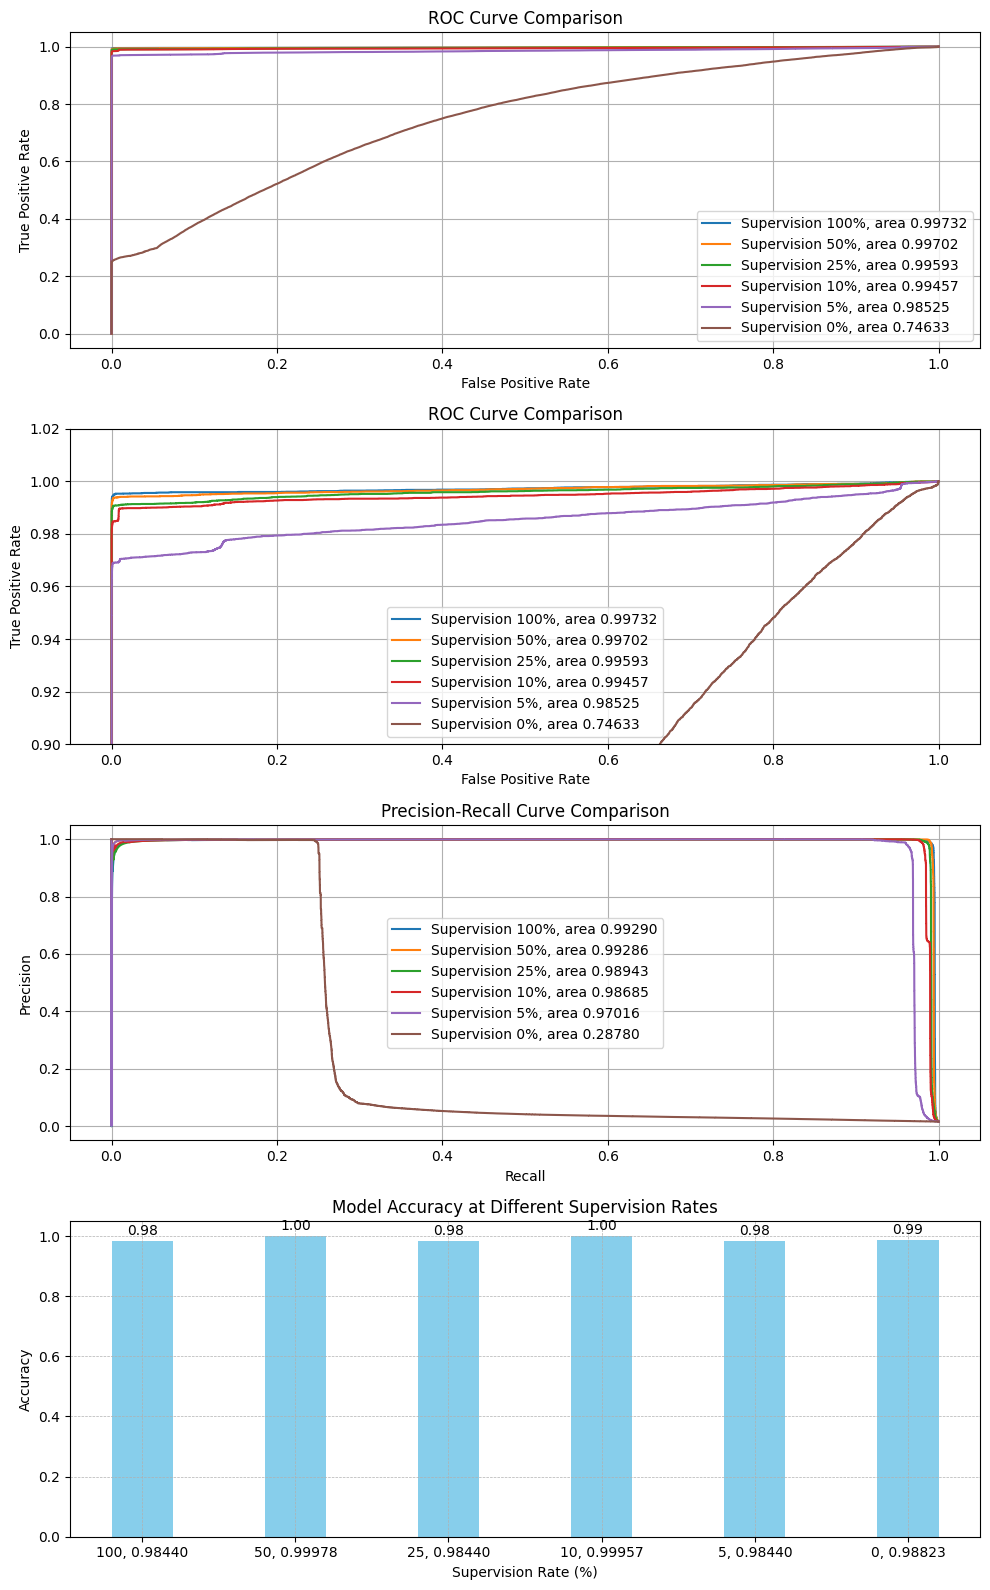

In [ ]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 0.1
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    
    # Store metrics
    metrics_dict['fpr'][supervision_rate] = fpr
    metrics_dict['tpr'][supervision_rate] = tpr
    metrics_dict['precision'][supervision_rate] = precision
    metrics_dict['recall'][supervision_rate] = recall
    metrics_dict['accuracy'][supervision_rate] = accuracy    
    
    # Separate anomaly scores based on the labels
    # plot_graph(anomaly_scores, y_test[:1000])
  fig, ax = plt.subplots(4, 1, figsize=(10, 16))  # Create a figure and a set of subplots.

  # Plot ROC curves on the first subplot
  plot_comparison_graph(metrics_dict)



anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate_list = [1.0, 0.5, 0.25, 0.1, 0.05, 0.0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


0.17647031081142991


In [21]:
X_train.shape

(261925, 82)

### 0.15 data for training in 0.1 supervision vs 0.85 for training in 0.05 or 0

In [31]:
# Read the csv and clean it
df = read_csv()
def eval_model_unsupervised(supervision_rate_list, model):
  anomaly_rate = 0.05
  metrics_dict = {
      'fpr': {},
      'tpr': {},
      'precision': {},
      'recall': {},
      'accuracy': {}
  }
  for supervision_rate in supervision_rate_list:
    # supervision = False
    improved_df = df.copy()
    # Clean the labels
    attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]
    improved_df.drop(['Attempted Category'], axis = 1, inplace = True)
    improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
    # Sample the Anomaly Rate
    #### Sample out Malicious data such that it would become an outlier
    print(f'improved_df.shape {improved_df.shape} Before Sampling Out')
    improved_df = pd.concat([improved_df[improved_df['Label'] == 'BENIGN'], improved_df[improved_df['Label'] != 'BENIGN'].sample(frac=anomaly_rate, random_state=42)]) 
    print(f'improved_df.shape {improved_df.shape} after Sampling Out')
    ratio = improved_df.loc[improved_df["Label"] == "BENIGN"].shape[0]/ improved_df.loc[improved_df["Label"] != "BENIGN"].shape[0]
    print(f'Ratio of Benign to Anomaly is {ratio} : 1')
    # Dataset
    scaler = StandardScaler()
    Y = improved_df['Label'].map({"BENIGN":0}).fillna(1)
    X = improved_df.copy().drop(columns=["Label"], axis=1)
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    train_perc = 0.15 if supervision_rate == 0.1 else 0.3

    # benign training and testing

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        Y, 
                                                        test_size = 1-train_perc, 
                                                        shuffle = True, 
                                                        stratify = Y, 
                                                        random_state = 0)
    # Start Training
    idx = np.where(y_train==1)[0]
    y = np.zeros_like(y_train.values)
    if supervision_rate == 0:
      print(f"UNSUPERVISED, Sampling Rate = {anomaly_rate}")
      y[idx[:2]] = 1
    else:
      print(f"SEMI SUPERVISED, Sampling Rate = {anomaly_rate}, Supervision = {supervision_rate}")
      idx = np.random.choice(idx, size=int(supervision_rate*len(idx)), replace=False)
      y[idx] = 1
    
    clf = model( device = 'cuda', verbose=1, epochs=1)
    clf.fit(X=X_train.to_numpy(), y = y)
    # pred = clf.predict(X_test.to_numpy())
    anomaly_scores = clf.decision_function(X_test.to_numpy())

    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    accuracy = accuracy_score(y_test, pred)
    get_score(pred, y_test)
    
    # Store metrics
    metrics_dict['fpr'][supervision_rate] = fpr
    metrics_dict['tpr'][supervision_rate] = tpr
    metrics_dict['precision'][supervision_rate] = precision
    metrics_dict['recall'][supervision_rate] = recall
    metrics_dict['accuracy'][supervision_rate] = accuracy    
    
    # Separate anomaly scores based on the labels
  # plot_graph(anomaly_scores, y_test[:1000])
  plot_comparison_graph(metrics_dict, supervision_rate_list)

anomaly_rate_list = [1.0, 0.5, 0.3, 0.1, 0.05]
supervision_rate_list = [0.1, 0.05, 0.01, 0]

model = PReNet
eval_model_unsupervised(supervision_rate_list, model)


dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.1
Start Training...
ensemble size: 1
epoch  1, training loss: 0.195794, time: 264.1s
Start Inference on the training data...
Accuracy: 0.9993
Precision: 0.9587
Recall: 0.9951
F1 Score: 0.9766
[[1355259     887]
 [    101   20594]]
improved_df.shape (2099971, 83) Before Sampling Out
improved_df.shape (1619812, 83) after Sampling Out
Ratio of Benign to Anomaly is 63.09512503956948 : 1
SEMI SUPERVISED, Sampling Rate = 0.05, Supervision = 0.05
Start Training...
